YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 5.5150e-04 - val_loss: 0.0032
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 4.9170e-04 - val_loss: 0.0030
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.0103e-04 - val_loss: 0.0046
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.8282e-04 - val_loss: 0.0049
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 3.4777e-04 - val_loss: 0.0020
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.1703e-04 - val_loss: 0.0033
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 2.8979e-04 - val_loss: 0.0034
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 2.7228e-04 - val_loss: 0.0027
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.7600e-04 - val_loss: 0.0022
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.4029e-04 - val_loss: 0.0060
Epoch 12/20
62/62 ━━━━━

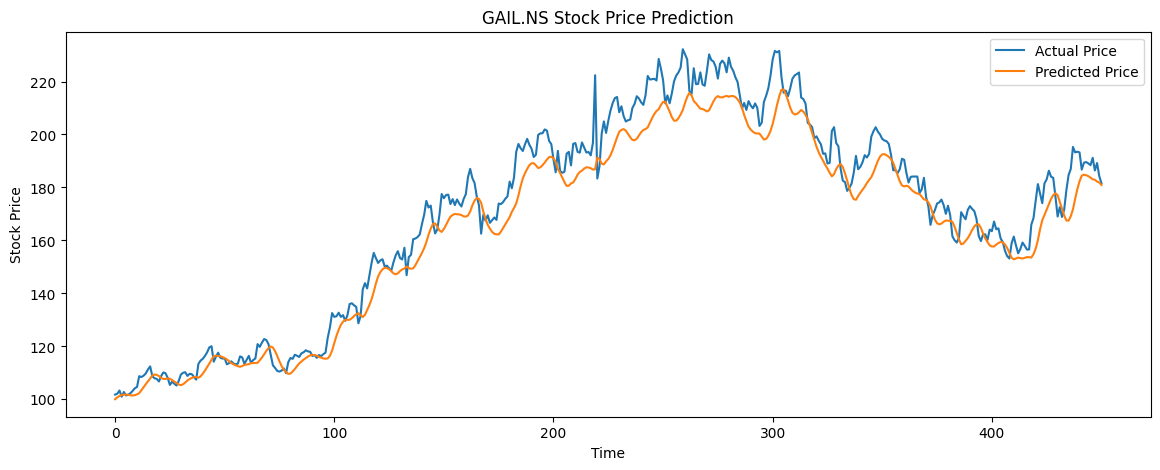

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Step 1: Data Collection
def get_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    return df

# Step 2: Load Data
stock_ticker = 'GAIL.NS'  # GAIL India stock
start_date = '2015-01-01'
end_date = '2025-05-11'
data = get_stock_data(stock_ticker, start_date, end_date)

# Step 3: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data[['Close']])

train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60  # Lookback period of 60 days
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Step 4: Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Predict Future Price for 12-03-2025
last_60_days = data_scaled[-seq_length:]
last_60_days = np.array(last_60_days).reshape(1, seq_length, 1)
predicted_price = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Closing Price for BSE on 12-03-2025: {predicted_price[0][0]:.2f}")

# Step 7: Plot Results
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(14,5))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.title(f'{stock_ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()
